# 데이터 획득 및 설정

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import graphviz
import os
from sklearn import tree, ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, RobustScaler

from mclLib.server_info import *
from mclLib.featurenames import *


os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/' # windows에서 graphviz를 사용하기 위해 변수경로 설정 

c:\Users\all\anaconda3\envs\AtoEnvironment\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\all\anaconda3\envs\AtoEnvironment\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

In [2]:
engine = create_engine(mysql_server_uri)
conn = engine.connect()

In [3]:
br_full_data = pd.read_sql_table('buyreports', conn)

# Filtering

In [4]:
# Filtering
get_filter = ( br_full_data['isAllBuyed'] == 1) & ( br_full_data['isAllSelled'] == 1)
br = br_full_data[get_filter]

In [5]:

feature_names = f_name_102

feature_size = len(feature_names)
feat_name = np.array(feature_names)
features = feature_names

In [6]:
X = br[features].to_numpy(dtype=np.float64)

In [7]:
y_condition = (br['fMaxPowerAfterBuyWhile10'] >= 0.025)
y = np.where(y_condition, 1, 0)

In [8]:
X = X.astype(np.float32)

In [9]:
X.shape

(14265, 102)

# VarianceThreshold

In [10]:
selector = VarianceThreshold(threshold=1)
robust = RobustScaler()
X_scaled = robust.fit_transform(X)
train_thresh = selector.fit(X_scaled)
features_out = train_thresh.get_feature_names_out(features)

print(features_out.shape)
print(features_out)

(63,)
['nBuyStrategyIdx' 'fStartGap' 'fMinusCnt07' 'fMinusCnt09'
 'fOnlyDownPowerJar' 'nChegyulCnt' 'nMissCnt' 'lTotalTradeVolume'
 'lTotalBuyVolume' 'lTotalSellVolume' 'nAccumUpDownCount' 'fAccumUpPower'
 'fAccumDownPower' 'lTotalTradePrice' 'lTotalBuyPrice' 'lTotalSellPrice'
 'lMarketCap' 'nAccumCountRanking' 'nPowerRanking'
 'nTotalTradePriceRanking' 'nTotalTradeVolumeRanking' 'nTotalRank'
 'nMinuteTotalRank' 'nMinuteTradePriceRanking' 'nMinuteTradeVolumeRanking'
 'nMinuteBuyPriceRanking' 'nMinuteBuyVolumeRanking' 'nMinutePowerRanking'
 'nMinuteCountRanking' 'nMinuteUpDownRanking' 'nFakeBuyCnt'
 'nFakeAssistantCnt' 'nPriceDownCnt' 'nUpTailCnt' 'nDownTailCnt'
 'nCandleTwoOverRealNoLeafCnt' 'fSpeedCur' 'fTradeCur' 'fPureTradeCur'
 'fPureBuyCur' 'fSharePerHoga' 'fSharePerTrade' 'fHogaPerTrade'
 'fTradePerPure' 'fMaDownFsVal' 'fMa20mVal' 'fMa1hVal' 'fMa2hVal'
 'fMaxMaDownFsVal' 'fMaxMa20mVal' 'fMaxMa1hVal' 'fMaxMa2hVal'
 'nMaxMaDownFsTime' 'nMaxMa20mTime' 'nMaxMa1hTime' 'nMaxMa2hTime'
 

# SelectKBest

In [11]:
# 분석방법 
#For classification: chi2, f_classif, mutual_info_classif

In [12]:
selector = SelectKBest(score_func=f_classif, k=20)

In [13]:
X_selected = selector.fit_transform(X, y)

In [14]:

## selector.get_support()
selected_mask = selector.get_support()
## 선택된 특성(변수)들
selected_names = feat_name[selected_mask]
## 선택되지 않은 특성(변수)들
unselected_names = feat_name[~selected_mask]
print('Selected names: ', selected_names, end='\n\n')
print('Unselected names: ', unselected_names)

Selected names:  ['fPowerWithOutGap' 'fPower' 'fPlusCnt07' 'fMinusCnt07' 'fPlusCnt09'
 'fMinusCnt09' 'fPowerJar' 'fOnlyUpPowerJar' 'nHogaCnt' 'nFakeResistCnt'
 'fSpeedCur' 'fSharePerTrade' 'fMaxMa20mVal' 'fMaxMa1hVal' 'nMaxMa1hTime'
 'nMaxMa2hTime' 'fRSlope' 'fDSlope' 'fRAngle' 'fDAngle']

Unselected names:  ['nBuyStrategyIdx' 'nRqTime' 'fStartGap' 'fOnlyDownPowerJar' 'nTradeCnt'
 'nChegyulCnt' 'nNoMoveCnt' 'nFewSpeedCnt' 'nMissCnt' 'lTotalTradeVolume'
 'lTotalBuyVolume' 'lTotalSellVolume' 'nAccumUpDownCount' 'fAccumUpPower'
 'fAccumDownPower' 'lTotalTradePrice' 'lTotalBuyPrice' 'lTotalSellPrice'
 'lMarketCap' 'nAccumCountRanking' 'nMarketCapRanking' 'nPowerRanking'
 'nTotalBuyPriceRanking' 'nTotalBuyVolumeRanking'
 'nTotalTradePriceRanking' 'nTotalTradeVolumeRanking' 'nTotalRank'
 'nMinuteTotalRank' 'nMinuteTradePriceRanking' 'nMinuteTradeVolumeRanking'
 'nMinuteBuyPriceRanking' 'nMinuteBuyVolumeRanking' 'nMinutePowerRanking'
 'nMinuteCountRanking' 'nMinuteUpDownRanking' 'nFakeBuyCnt'

# SelectFromModel

In [15]:
# will select those features which importance is greater than the mean importance of all the features by default
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)

selected_feat = feat_name[selector.get_support()]
selected_feat

array(['fPowerWithOutGap', 'fPower', 'fPlusCnt07', 'fMinusCnt07',
       'fPlusCnt09', 'fMinusCnt09', 'fPowerJar', 'fOnlyUpPowerJar',
       'nHogaCnt', 'nFakeResistCnt', 'fSpeedCur', 'fSharePerTrade',
       'fMaxMa20mVal', 'fMaxMa1hVal', 'nMaxMa1hTime', 'nMaxMa2hTime',
       'fRSlope', 'fDSlope', 'fRAngle', 'fDAngle'], dtype='<U27')

# Decision Tree - Classifer

In [16]:
clf = tree.DecisionTreeClassifier(max_depth=10)
#clf = tree.ExtraTreeClassifier(max_depth= 5)
clf = clf.fit(X, y)

In [17]:
dot_data = tree.export_graphviz(clf,   # 의사결정나무 모형 대입
                               out_file = None,  # file로 변환할 것인가
                               feature_names = features,  # feature 이름
                               class_names = np.array(['fail', 'suc']),  # target 이름
                               filled = True,           # 그림에 색상을 넣을것인가
                               rounded = True,          # 반올림을 진행할 것인가
                               special_characters = True)   # 특수문자를 사용하나

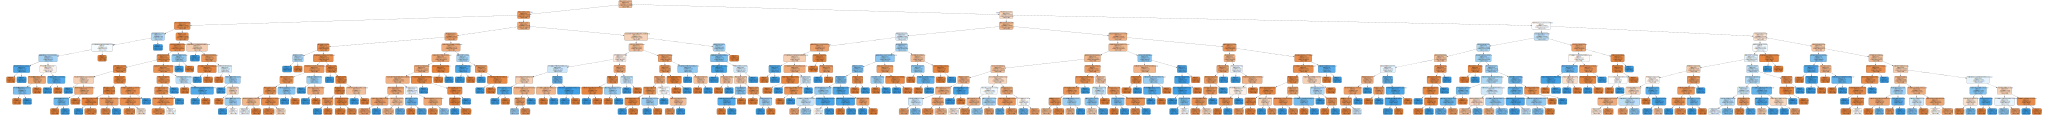

In [18]:
graph = graphviz.Source(dot_data)
graph

# Random Forest

#### Random Forest Built-in Feature Importance

In [19]:
rf = RandomForestClassifier(n_estimators=10, max_depth=5)
rf.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=10)

In [20]:
rf.feature_importances_ # 피처들의 중요도

array([2.61133081e-02, 8.32886402e-03, 1.02583677e-03, 1.03338445e-02,
       2.20268002e-02, 1.46593001e-01, 2.07158288e-03, 4.50388199e-02,
       1.03618238e-02, 1.68963657e-01, 3.07781014e-03, 5.11758753e-02,
       0.00000000e+00, 6.11975279e-03, 1.72822050e-03, 3.15845195e-03,
       4.84029711e-03, 1.27241295e-03, 4.61636109e-03, 1.13749683e-03,
       1.00756456e-02, 3.23602418e-03, 9.78502556e-03, 6.22172779e-03,
       1.25899739e-02, 6.97540902e-03, 7.68136526e-03, 9.78517300e-03,
       9.85777814e-03, 2.85632784e-03, 6.40063420e-03, 2.82377774e-03,
       0.00000000e+00, 3.34458179e-03, 2.97046850e-04, 2.90566468e-03,
       3.45157762e-03, 9.11639703e-03, 7.12285464e-03, 1.11532142e-03,
       2.34359951e-03, 3.06049682e-03, 4.21449905e-03, 3.60554415e-03,
       8.87719963e-04, 0.00000000e+00, 5.58319395e-03, 8.81808590e-04,
       1.29890843e-03, 1.44295421e-04, 2.27764739e-03, 0.00000000e+00,
       1.28360276e-03, 2.43471372e-03, 0.00000000e+00, 0.00000000e+00,
      

In [21]:
# plt.figure(figsize=(20, 20))
# plt.barh(feat_name, rf.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

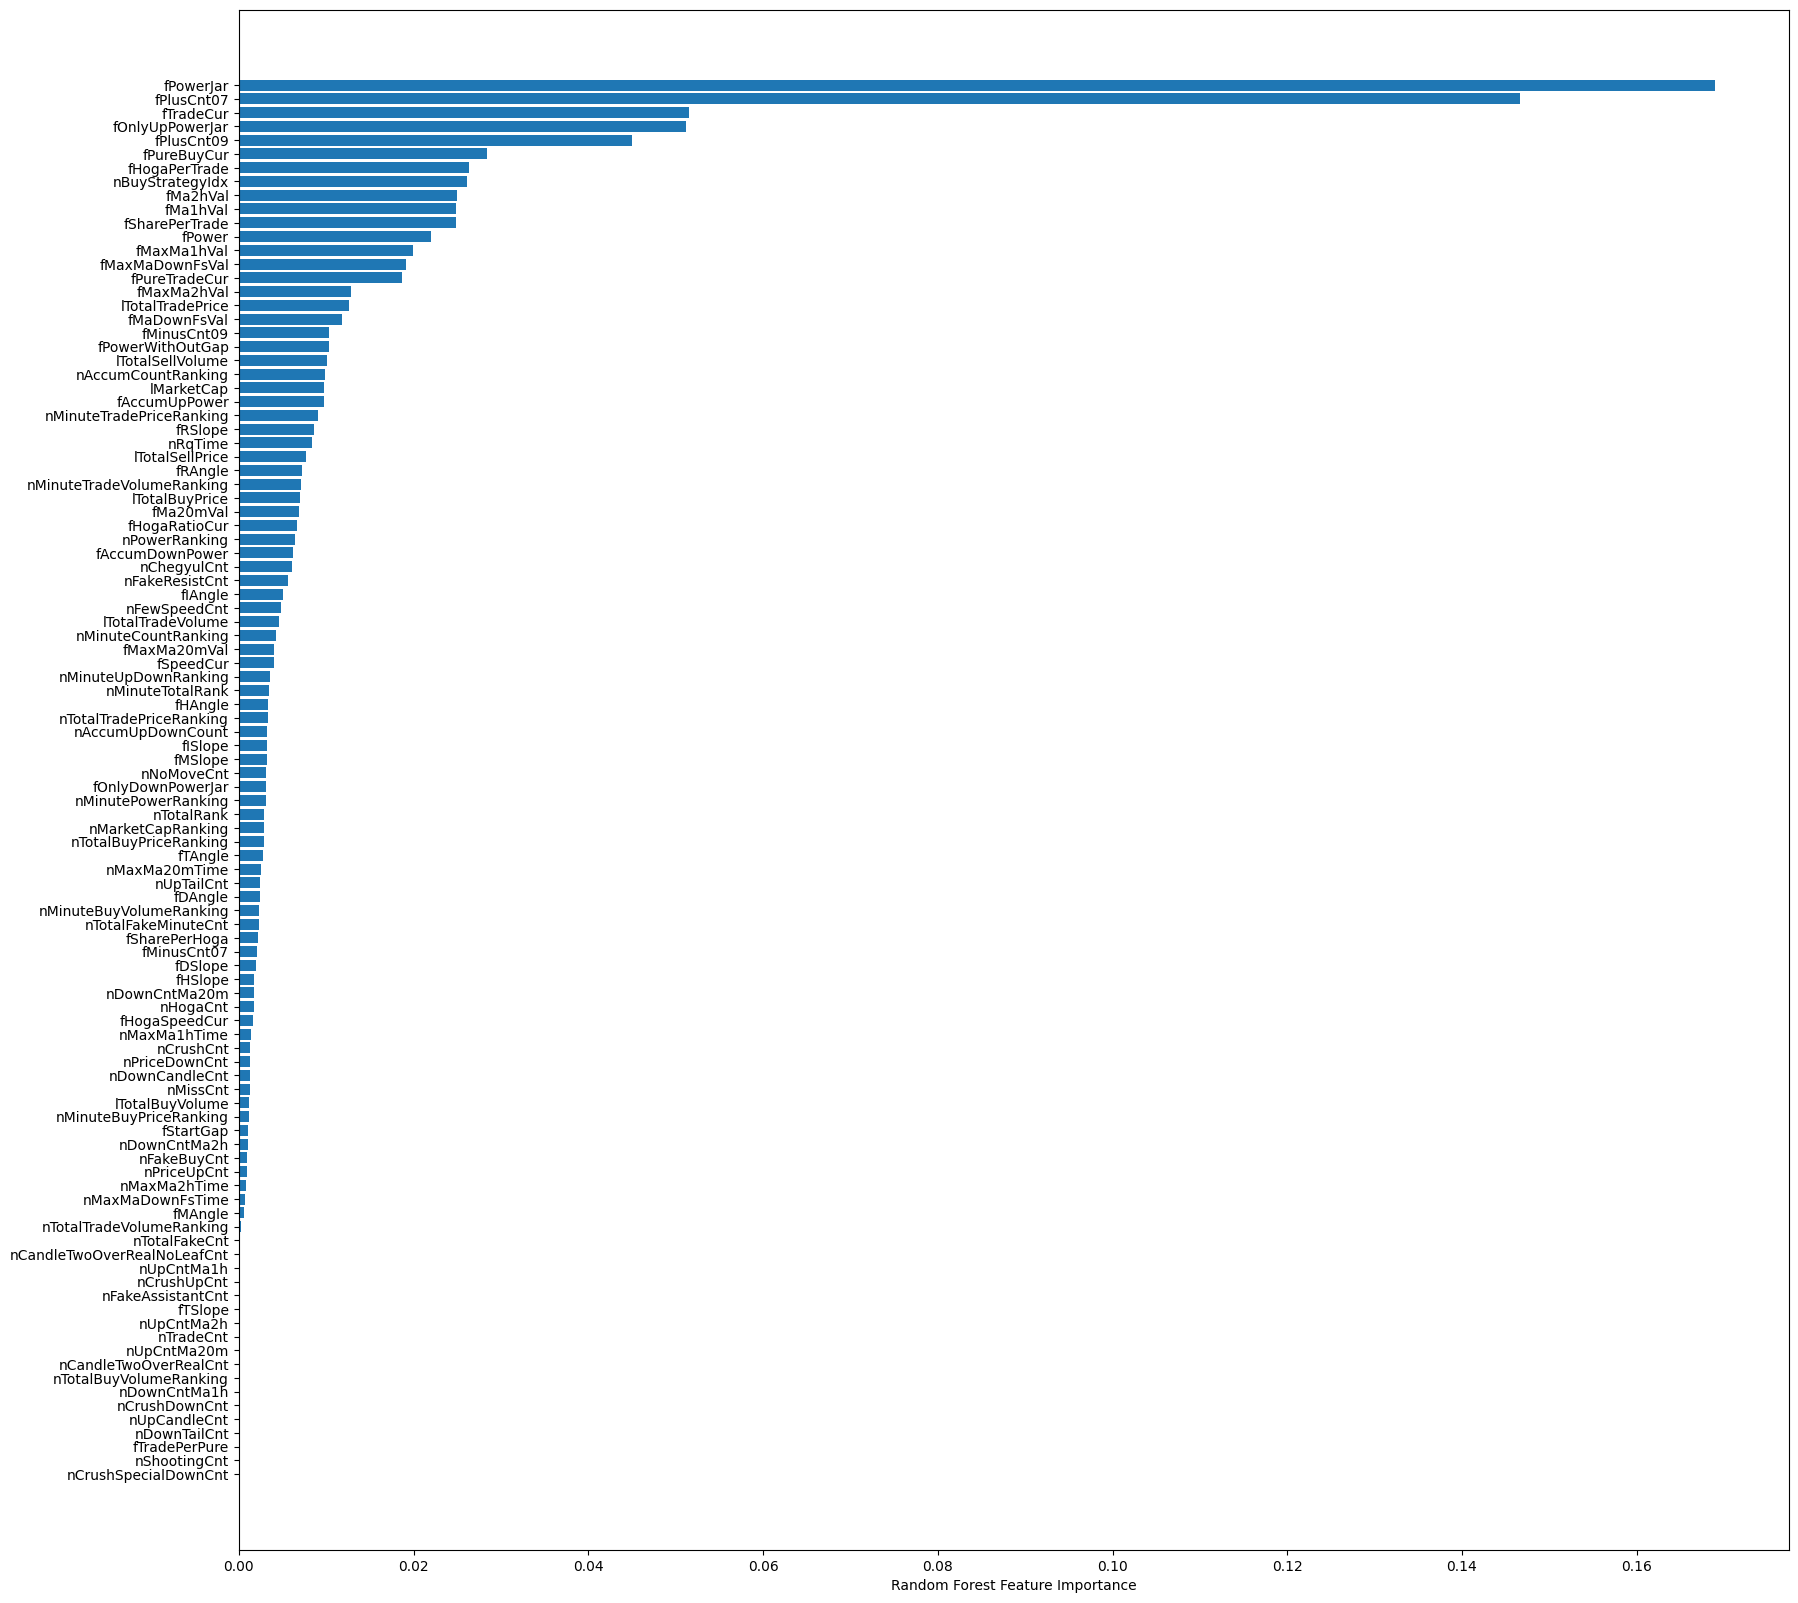

In [22]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(20, 20))
plt.barh(feat_name[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#### Permutation Based Feature Importance (with scikit-learn)

In [23]:
perm_importance = permutation_importance(rf, X, y)

Text(0.5, 0, 'Permutation Importance')

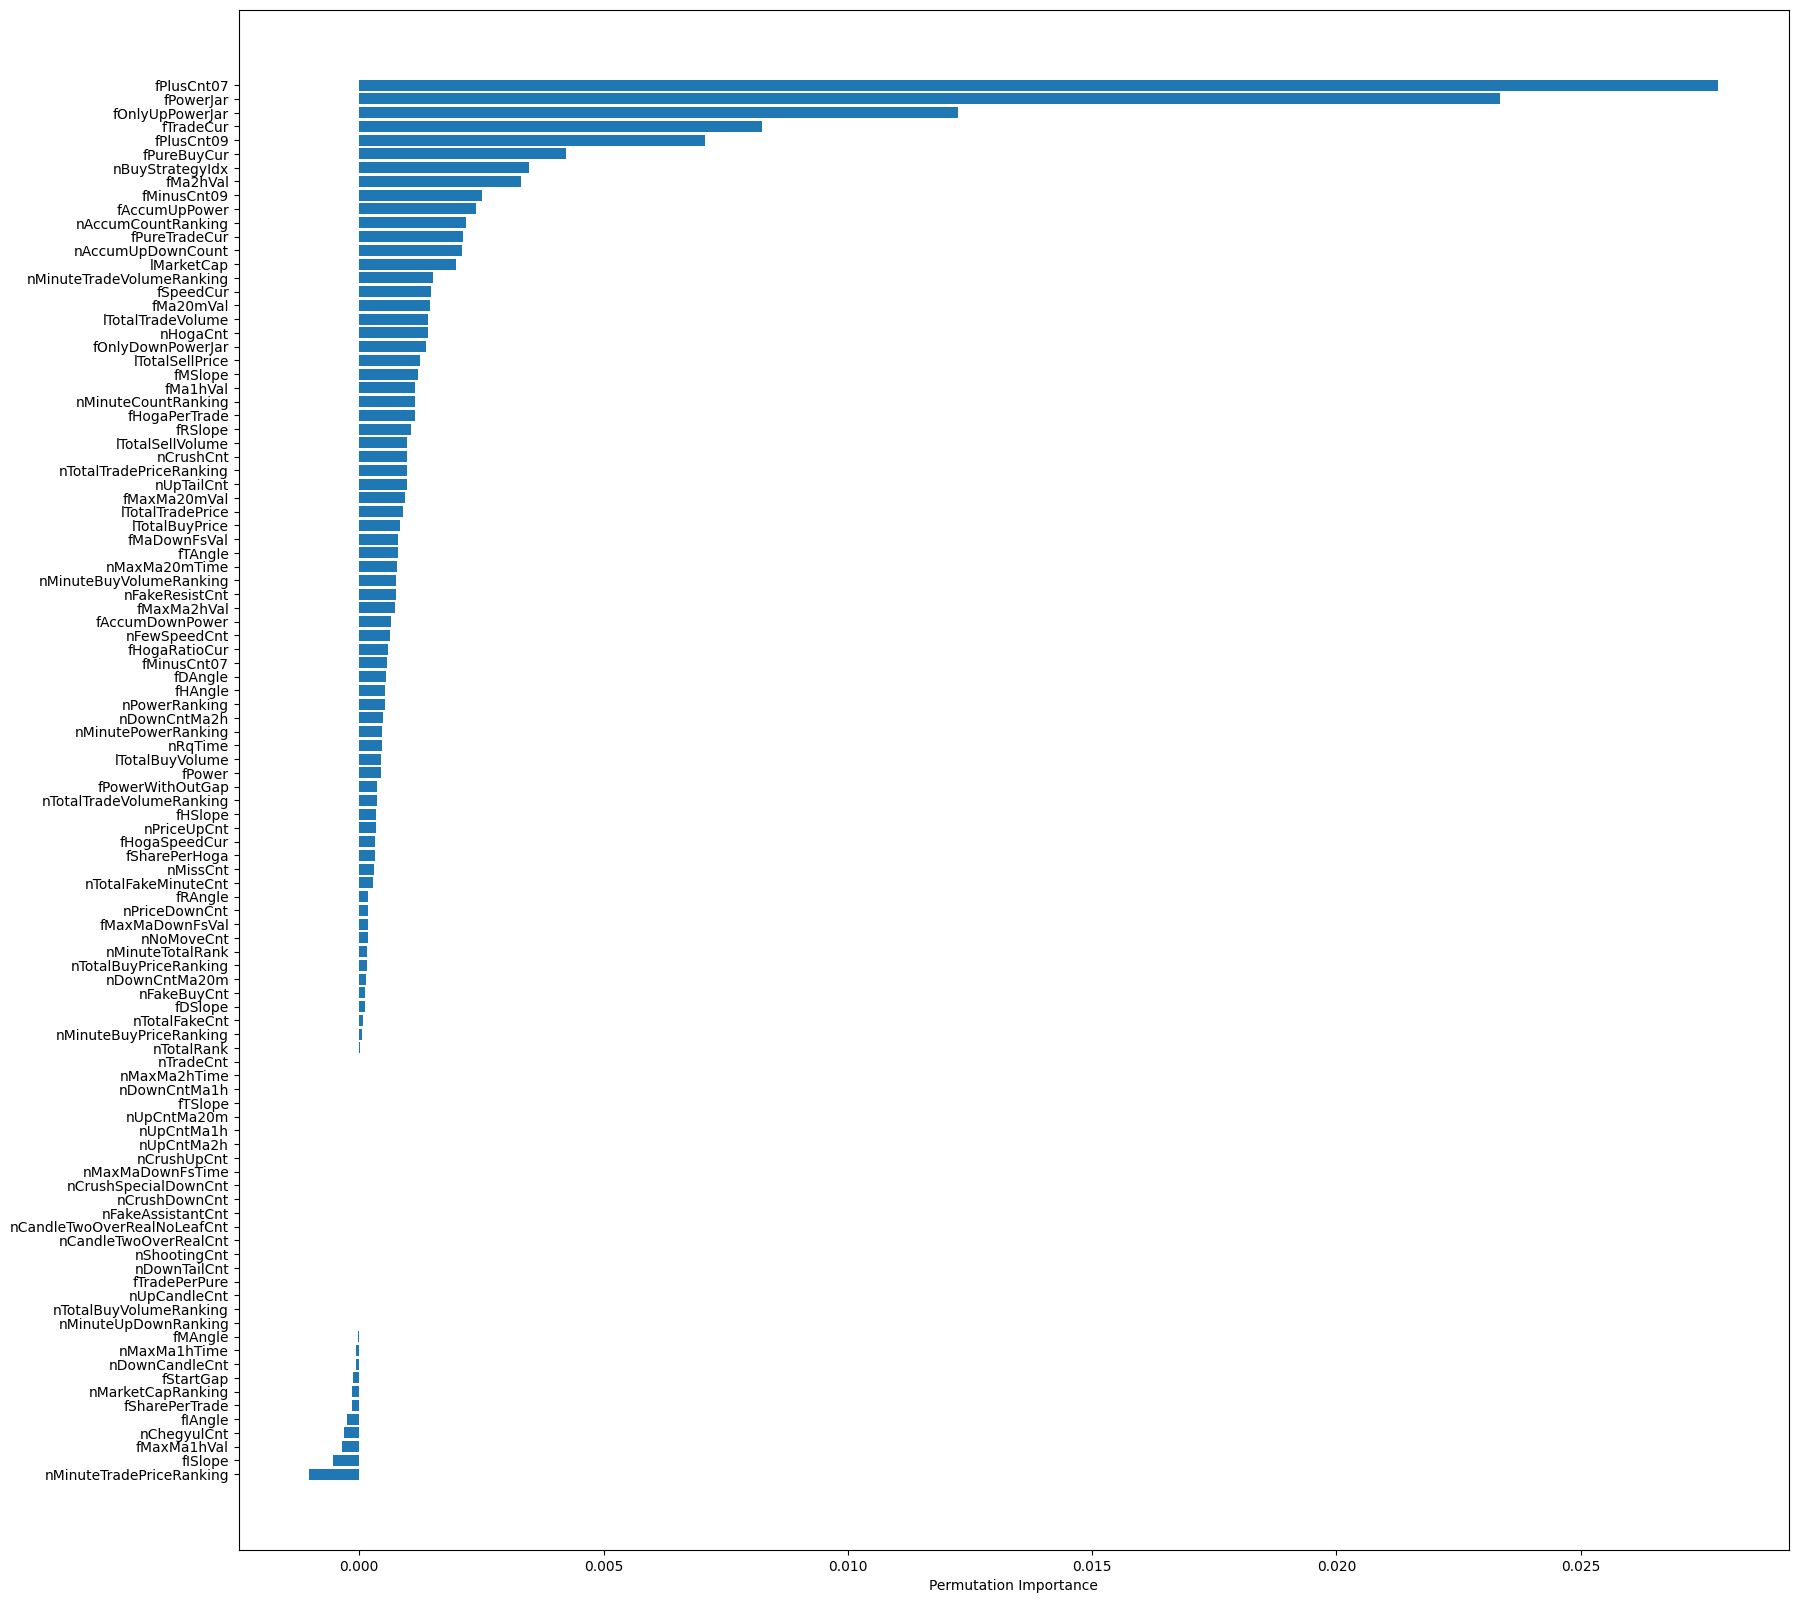

In [24]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(20, 20))
plt.barh(feat_name[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#### Feature Importance Computed with SHAP Values

Shap plot에 대해서  
Ref : https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a  
Ref( Kernel Shap vs Tree Shap ) : https://towardsdatascience.com/kernelshap-vs-treeshap-e00f3b3a27db
1. 요약플롯 summary_plot()
2. 종속성플롯 : dependency_plot()
3. 개별힘플롯 : force_plot(각각)
4. 집합력플롯 : force_plot()

In [25]:
# shaKernelExplainer은 feature갯수에 따라 시간이 지수적으로 올라감
rf2 = RandomForestClassifier(n_estimators=10)
rf2.fit(X, y)
explainer = shap.TreeExplainer(rf2) #트리가 아니고 선형회귀기반 중요도분석 KernelExplainer 단점 : 시간이 오래걸림, TreeExplainer도 오래걸림
shap_values = explainer.shap_values(X) # X_test에 관한 각각의 중요도 변수들?? 

In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feat_name) # plot_type  : 다양하게

In [ ]:
shap.summary_plot(shap_values, X, feature_names=feat_name)

In [ ]:
specific_var = "fPlusCnt07"
shap.dependence_plot(specific_var, shap_values, X, feature_names=feat_name)

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
specific_start_row = 2
specific_end_row = 3000

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[specific_start_row,:], X[specific_start_row,:],feature_names=feat_name)  

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[specific_start_row:,:], X[specific_start_row::,:], feature_names=feat_name)  